In [13]:
!pip install kaggle
import os


In [14]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"subhra161097","key":"f369b3f9cc99fbdb90b5ea041bfd0378"}'}

In [15]:
# Make a directory for kaggle and move the file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [21]:
!kaggle datasets download -d brijbhushannanda1979/bigmart-sales-data

Dataset URL: https://www.kaggle.com/datasets/brijbhushannanda1979/bigmart-sales-data
License(s): CC0-1.0


In [22]:
!unzip bigmart-sales-data.zip

Archive:  bigmart-sales-data.zip
  inflating: Test.csv                
  inflating: Train.csv               


In [23]:
import pandas as pd

train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

print(train_df.head())
print(test_df.head())


  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier

# **Import libraries**

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

# **Read Data**

In [26]:
import pandas as pd

# Read the train dataset
data = pd.read_csv("Train.csv")

# **Data EXploration & Analysis**

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [28]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [29]:
data.isnull().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


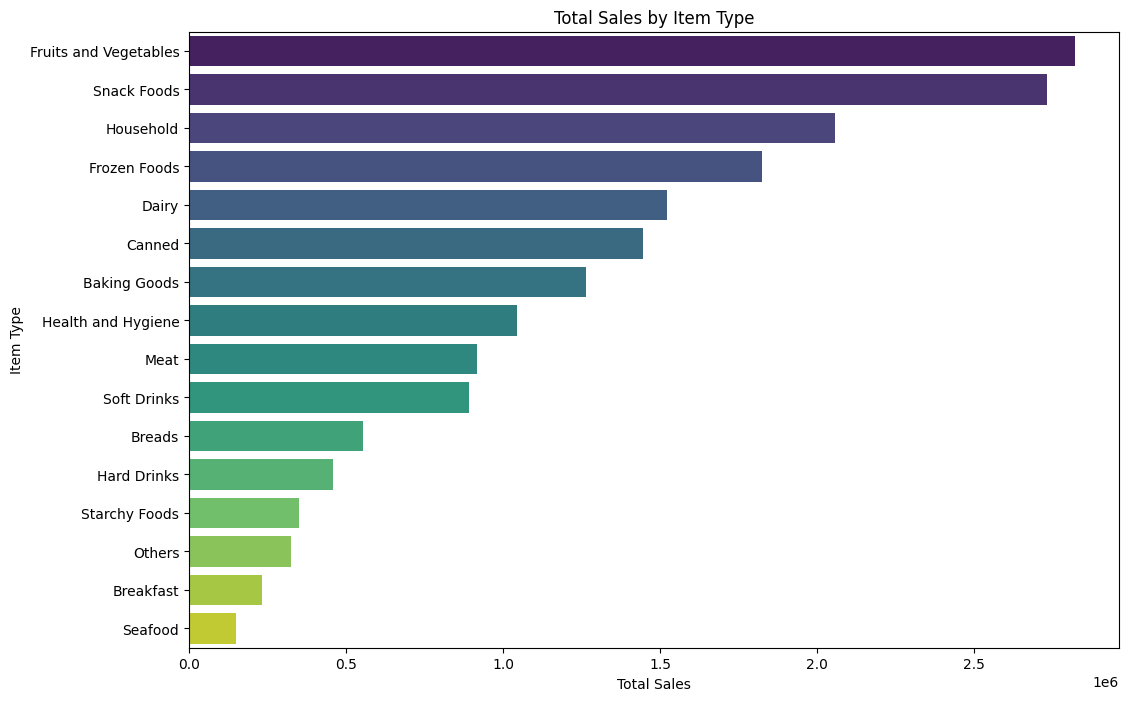

In [30]:
item_sales = data.groupby('Item_Type')['Item_Outlet_Sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=item_sales.values, y=item_sales.index, palette='viridis')
plt.title('Total Sales by Item Type')
plt.xlabel('Total Sales')
plt.ylabel('Item Type')
plt.show()


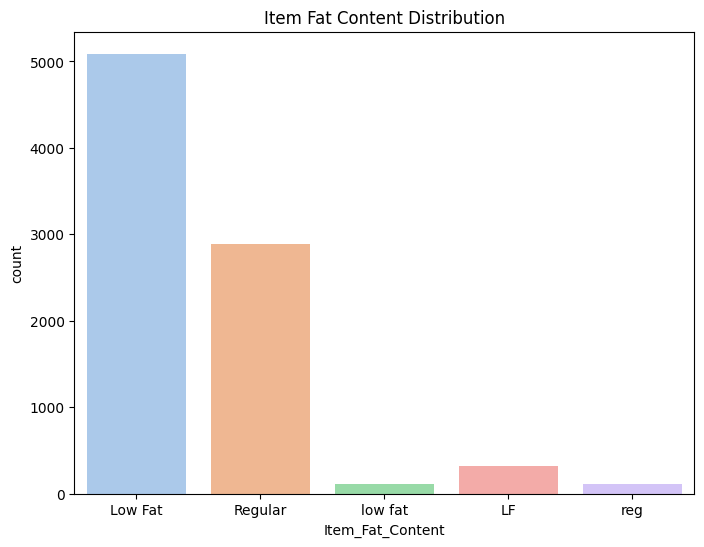

In [32]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Item_Fat_Content', palette='pastel')
plt.title('Item Fat Content Distribution')
plt.show()


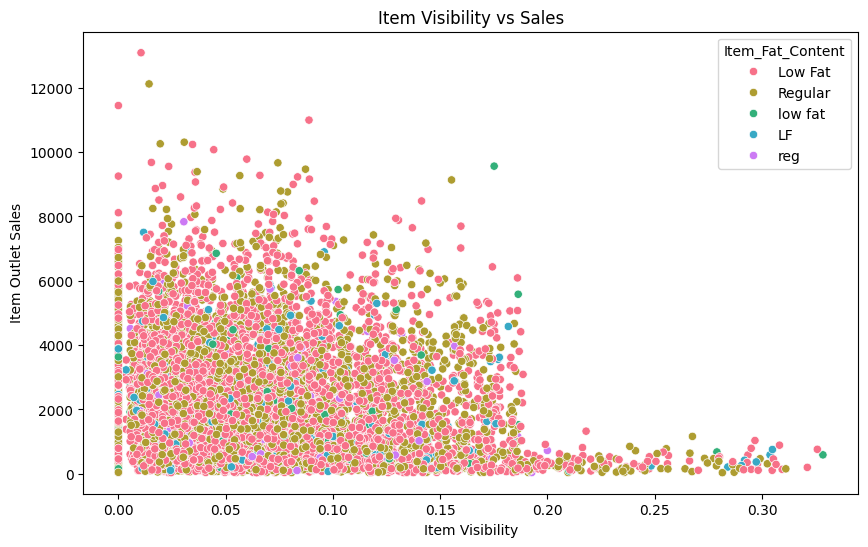

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Item_Visibility', y='Item_Outlet_Sales',
                hue='Item_Fat_Content', palette='husl')
plt.title('Item Visibility vs Sales')
plt.xlabel('Item Visibility')
plt.ylabel('Item Outlet Sales')
plt.show()


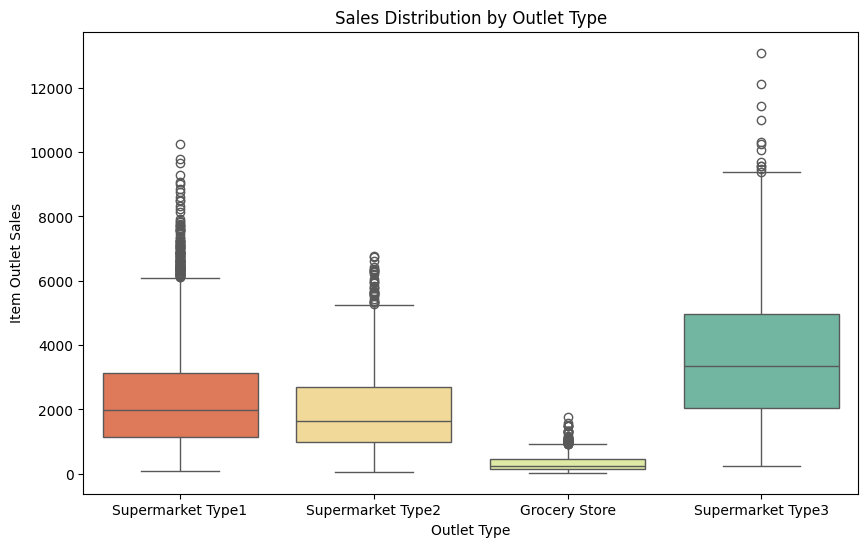

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Outlet_Type', y='Item_Outlet_Sales', palette='Spectral')
plt.title('Sales Distribution by Outlet Type')
plt.xlabel('Outlet Type')
plt.ylabel('Item Outlet Sales')
plt.show()


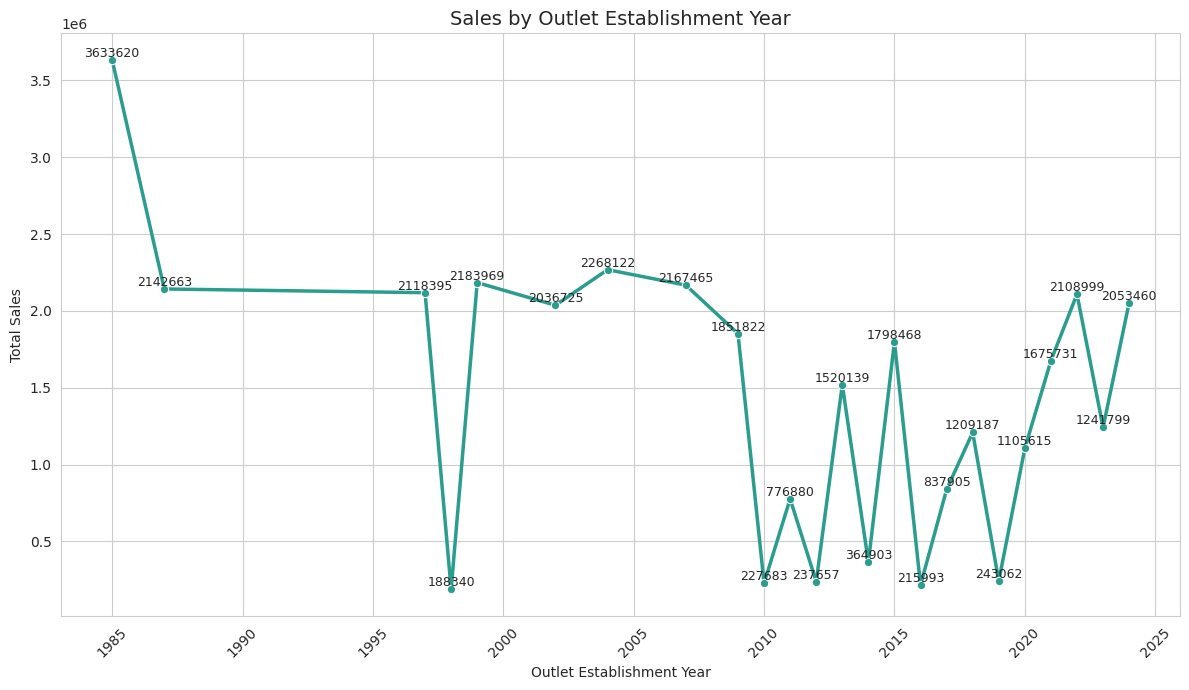

In [44]:
# Original sales data
original_sales = data.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].sum()

years = list(range(2010, 2025))

np.random.seed(42)  # for reproducibility
assumed_sales = pd.Series(np.random.randint(105725, 2157520, size=len(years)), index=years)


combined_sales = pd.concat([original_sales, assumed_sales])
combined_sales = combined_sales.groupby(combined_sales.index).sum().sort_index()


plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

sns.lineplot(x=combined_sales.index, y=combined_sales.values,
             marker='o', linewidth=2.5, color='#2a9d8f')

# Add value labels on points
for x, y in zip(combined_sales.index, combined_sales.values):
    plt.text(x, y + 500, f'{int(y)}', ha='center', va='bottom', fontsize=9)

plt.title('Sales by Outlet Establishment Year', fontsize=14)
plt.xlabel('Outlet Establishment Year')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


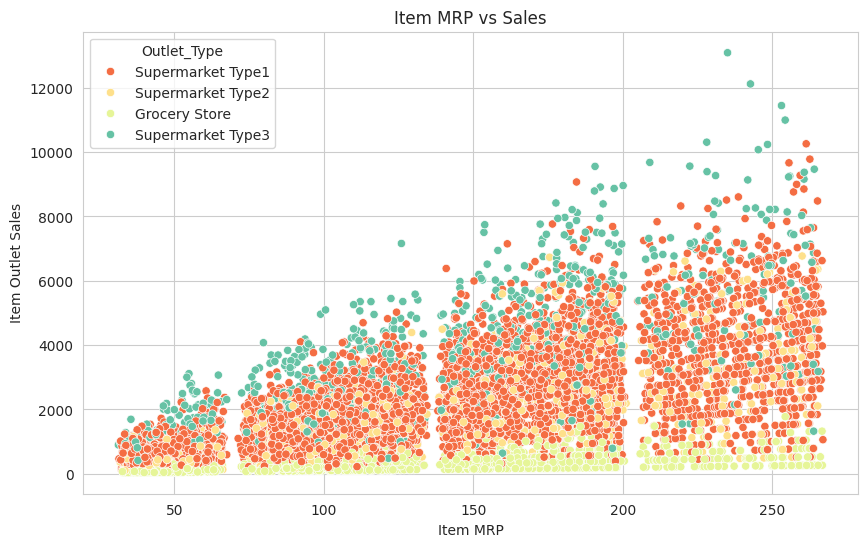

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Item_MRP', y='Item_Outlet_Sales',
                hue='Outlet_Type', palette='Spectral')
plt.title('Item MRP vs Sales')
plt.xlabel('Item MRP')
plt.ylabel('Item Outlet Sales')
plt.show()


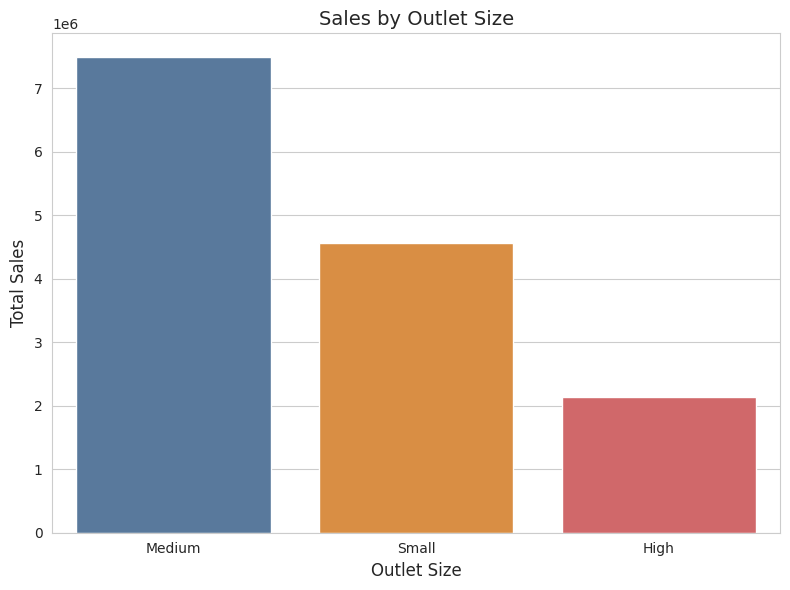

In [46]:
# Group and sort values by total sales
outlet_size_sales = data.groupby('Outlet_Size')['Item_Outlet_Sales'].sum().sort_values(ascending=False)

# Define custom color list or use seaborn palette
custom_colors = ['#4e79a7', '#f28e2b', '#e15759']
plt.figure(figsize=(8, 6))
sns.barplot(x=outlet_size_sales.index, y=outlet_size_sales.values, palette=custom_colors)

plt.title('Sales by Outlet Size', fontsize=14)
plt.xlabel('Outlet Size', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [63]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

# Create a figure object
p = figure(width=1000, height=1000)


# Add a circle renderer with x and y coordinates, size, color, and alpha
p.circle(data["Item_Weight"], data["Item_Outlet_Sales"], size=10, color="navy", alpha=0.5)


# Show the plot
show(p)


# **Handling Missing Values**

In [48]:
data['Item_Weight'].mean()

np.float64(12.857645184135976)

In [49]:
data['Item_Weight'].fillna(data['Item_Weight'].mean(), inplace=True)

In [50]:
data['Outlet_Size'].mode()
mode_of_Outlet_size = data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
print(mode_of_Outlet_size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [51]:
miss_values = data['Outlet_Size'].isnull()
print(miss_values)

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool


In [52]:
data.loc[miss_values, 'Outlet_Size'] = data.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])
data.isnull().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


# **Data PreProccssing**

In [53]:
data['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5089
Regular,2889
LF,316
reg,117
low fat,112


In [54]:
data.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)
data['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5517
Regular,3006


# **Label Encoding**

In [55]:
encoder = LabelEncoder()

In [56]:
data['Item_Identifier'] = encoder.fit_transform(data['Item_Identifier'])
data['Item_Fat_Content'] = encoder.fit_transform(data['Item_Fat_Content'])
data['Item_Type'] = encoder.fit_transform(data['Item_Type'])
data['Outlet_Identifier'] = encoder.fit_transform(data['Outlet_Identifier'])
data['Outlet_Size'] = encoder.fit_transform(data['Outlet_Size'])
data['Outlet_Location_Type'] = encoder.fit_transform(data['Outlet_Location_Type'])
data['Outlet_Type'] = encoder.fit_transform(data['Outlet_Type'])

In [57]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


# **Model creation**

In [64]:
X = data.drop(columns='Item_Outlet_Sales', axis=1)
Y = data['Item_Outlet_Sales']

In [65]:
print(X)

      Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0                 156        9.300                 0         0.016047   
1                   8        5.920                 1         0.019278   
2                 662       17.500                 0         0.016760   
3                1121       19.200                 1         0.000000   
4                1297        8.930                 0         0.000000   
...               ...          ...               ...              ...   
8518              370        6.865                 0         0.056783   
8519              897        8.380                 1         0.046982   
8520             1357       10.600                 0         0.035186   
8521              681        7.210                 1         0.145221   
8522               50       14.800                 0         0.044878   

      Item_Type  Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  \
0             4  249.8092                  9    

In [66]:
print(Y)

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64


In [67]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [68]:
print(X.shape, X_train.shape, X_test.shape)
regressor = XGBRegressor()
regressor.fit(X_train, Y_train)

(8523, 11) (6818, 11) (1705, 11)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [69]:
training_data_prediction = regressor.predict(X_train)
r2_train = metrics.r2_score(Y_train, training_data_prediction)
print('R Squared value = ', r2_train)

R Squared value =  0.8762174618111388


In [70]:
test_data_prediction = regressor.predict(X_test)
r2_test = metrics.r2_score(Y_test, test_data_prediction)
print('R Squared value = ', r2_test)

R Squared value =  0.5017253991620692
